In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Auxiliar matrices

1) Pauli matrices as s0, sx, sy, sz, and a 2x2 zero block (zr)

2) 4x4 matrices $U_{i,j} = \tau_i \otimes \sigma_j$, but using the auxiliar Pauli matrices above for both tau and sigma

In [2]:
# Pauli matrices (auxiliar)
s0 = np.array([[1, 0],[0, 1]])
sx = np.array([[0, 1],[1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])
zr = 0*s0 # zero

# Uij matrices
U00 = np.kron(s0,s0)
Ux0 = np.kron(sx,s0)
Uy0 = np.kron(sy,s0)
Uz0 = np.kron(sz,s0)
U0x = np.kron(s0,sx)
Uxx = np.kron(sx,sx)
Uyx = np.kron(sy,sx)
Uzx = np.kron(sz,sx)
U0y = np.kron(s0,sy)
Uxy = np.kron(sx,sy)
Uyy = np.kron(sy,sy)
Uzy = np.kron(sz,sy)
U0z = np.kron(s0,sz)
Uxz = np.kron(sx,sz)
Uyz = np.kron(sy,sz)
Uzz = np.kron(sz,sz)

# Model for ribbons A and B

Using: $U_{i,j} = \tau_i \otimes \sigma_j$

$H_{AB} = \Delta_{AB} U_{z0} + \alpha(k_y U_{k} - k_x U_{xy}) + m_{AB} k_y^2 U_{c}^{AB}(\rho)$

$U_{k} = U_{xx}$

$U_{c}^{AB}(\rho) = \cosh(\rho)U_{z0} + \sinh(\rho)U_{00}$

## Model for ribbon C

Model for A-B is recovered for $\theta=\Delta_C=0$

$H_{C} = \Delta_{AB} U_{z0} + \alpha(k_y U_{k} - k_x U_{xy}) + \Delta_C U_{yx} + m_{C} k_y^2 U_{c}^{C}(\rho,\theta)$

$U_{c}^{C}(\rho,\theta) = \cos(\theta) U_{c}^{AB}(\rho) + \sin(\theta) U_{yx}$

In [3]:
def modelABC(y, k, DeltaAB, alpha, mABC, rho, theta=0, DeltaC=0):
    dy = y[1]-y[0] # discretization step
    Ny = len(y)    # number of points on the y-axis
    Nk = len(k)    # number of points in k
    
    # matrices to compose the discrete ky and ky² operators
    um = np.eye(Ny) # diagonal
    diagP = np.diag(np.ones(Ny-1), +1 ) # upper diagonal
    diagM = np.diag(np.ones(Ny-1), -1 ) # lower diagonal
    # discrete operators
    ky  = (-1j/(2*dy))*(diagP - diagM)
    ky2 = -(diagP -2*um + diagM)/(dy**2)

    # auxiliary internal function to calculate
    # eigenvalues and eigenvectors for a given k=qx
    def evals(qx, vecs=False):
        kx = um*qx # diagonal matrix form in the ky-space
        
        # common terms for A, B, and C ribbons
        h  = DeltaAB*np.kron(Uz0, um)*(1.0+0.0j)
        h += +alpha*np.kron(Uxx, ky)
        h += -alpha*np.kron(Uxy, kx)
        h += 0.5*mABC*np.kron(Uz0, ky2)*np.cosh(rho)*np.cos(theta)
        h += 0.5*mABC*np.kron(U00, ky2)*np.sinh(rho)*np.cos(theta)
        # terms allowed only for the C ribbon
        h += DeltaC*np.kron(Uyx, um)
        h += 0.5*mABC*np.kron(Uyx, ky2)*np.sin(theta)
        
        if vecs==False:
            # eigenvalues only
            return( np.linalg.eigvalsh(h) )
        else:
            # eigenvalues and eigenvectors
            return( np.linalg.eigh(h) )
    # end: evals

    # array to organize output
    # in this code we are interested only in the eigenvalues
    autoval = np.array([])
    for qx in k:
        eigval = evals(qx)
        autoval = np.append(autoval, eigval)
    # reshape to a matrix format appropriate for pyplot
    autoval = autoval.reshape((Nk, 4*Ny))
    return autoval

# Default parameters

Using $\Delta_{AB}=1$ as the energy unity, and $\alpha/\Delta_{AB}=1$ as the distance unit.

In [4]:
DeltaAB = 1 # gap
alpha = 1 # Fermi velocity
Ly = 5 # width
Ny = 101 # discretization
y = np.linspace(0, Ly, Ny)
kmax = 3 # range to plot
kx = np.linspace(-kmax, kmax, 101)

# value for the Wilson's mass
dE = 5
dy = y[1]-y[0]
Mmin = dy**2*dE/2
Mmax = (alpha**2)/dE
Mav = (Mmin+Mmax)/2 # using the average value between the extremes
# Mmin must be smaller than Mmax
print("Min=", Mmin, ", Max=", Mmax, ", Avg=", Mav)

Min= 0.006250000000000001 , Max= 0.2 , Avg= 0.10312500000000001


In [5]:
# varying rho for ribbons A, B with positive and negative masses

rhovec = np.linspace(-2,2, 101) # range of rho
ek0 = np.array([modelABC(y, [0], DeltaAB, alpha, +Mav, rho)[0] for rho in rhovec]) # M>0
ek1 = np.array([modelABC(y, [0], DeltaAB, alpha, -Mav, rho)[0] for rho in rhovec]) # M<0
band0 = modelABC(y, kx, DeltaAB, alpha, -Mav, +0.5) # illustrative example for the bands
band1 = modelABC(y, kx, DeltaAB, alpha, -Mav, -0.5) # illustrative example for the bands

In [6]:
# varying theta for ribbon C

thetavec = np.linspace(-np.pi/2,np.pi/2, 101) # range of theta
ek2 = np.array([modelABC(y, [0], DeltaAB, alpha, -Mav, 0, theta, 0)[0] for theta in thetavec])
bandsC4p = modelABC(y, kx, DeltaAB, alpha, -Mav, 0, theta=+np.pi/6, DeltaC=-0.2) # illustrative example for the bands

### Plotting Figure 5 of the paper

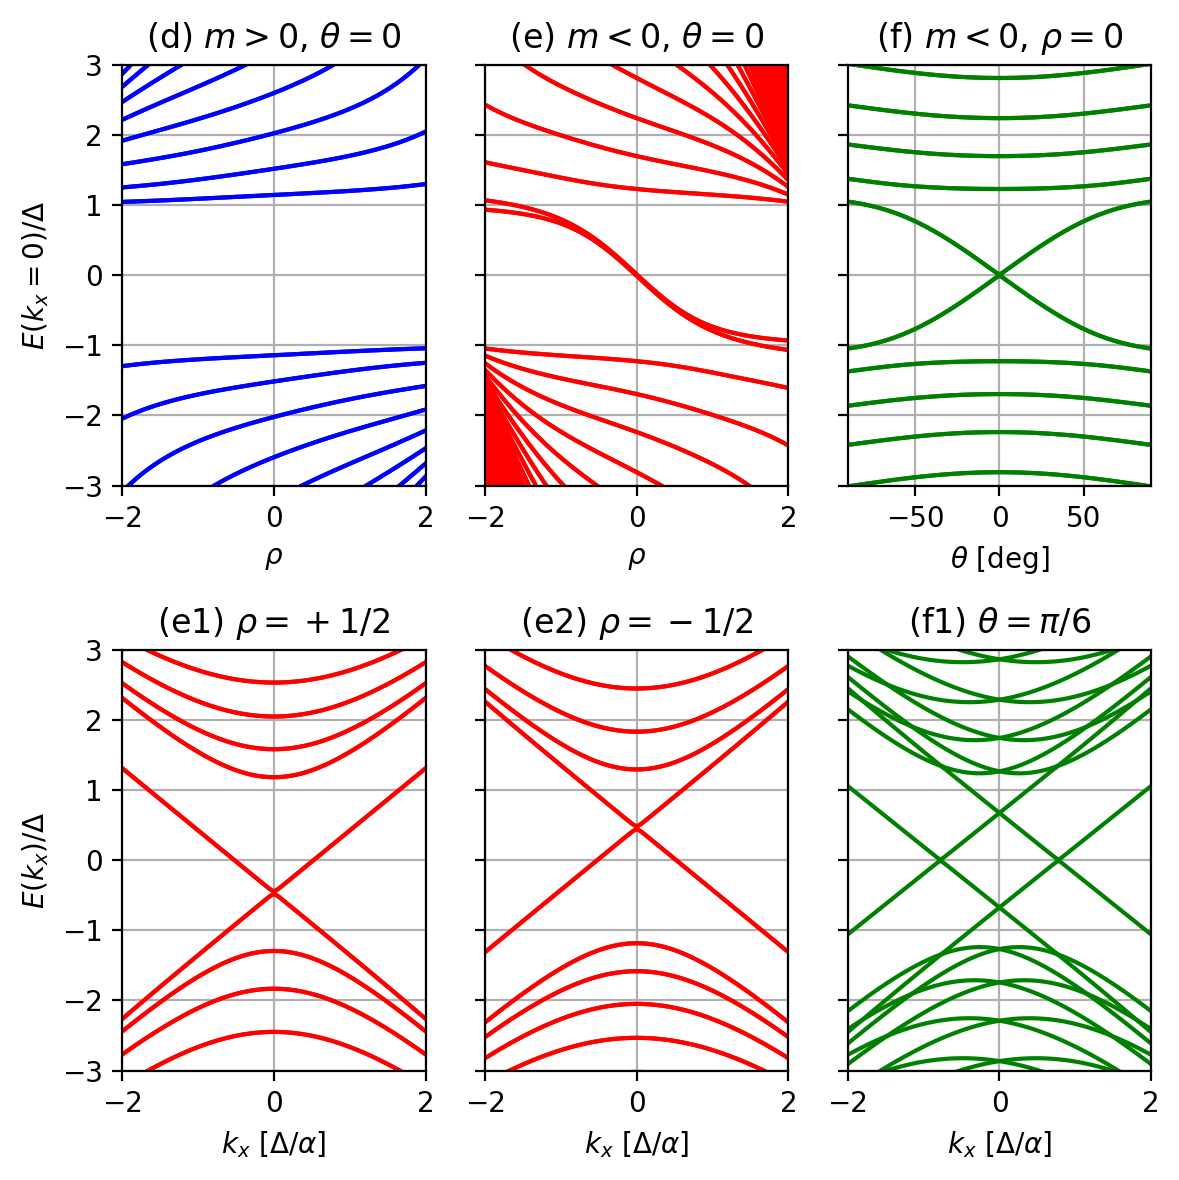

In [8]:
#plt.rcParams.update({'font.size': 12})
plt.figure(dpi=200, figsize=(6,6))

plt.subplot(231)
plt.title(R"(d) $m>0$, $\theta=0$")
plt.plot(rhovec, ek0, c='blue', rasterized=True)
plt.xlim([-2,2])
plt.ylim([-3,3])
plt.ylabel(R"$E(k_x=0)/\Delta$")
plt.xlabel(R"$\rho$")
plt.grid()

plt.subplot(232)
plt.title(R"(e) $m<0$, $\theta=0$")
plt.plot(rhovec, ek1, c='red', rasterized=True)
plt.xlim([-2,2])
plt.ylim([-3,3])
plt.xlabel(R"$\rho$")
plt.tick_params(labelleft=False)
plt.grid()

plt.subplot(233)
plt.title(R"(f) $m<0$, $\rho=0$")
plt.plot(thetavec*180/np.pi, ek2, c='green', rasterized=True)
plt.xlim([-90,90])
plt.ylim([-3,3])
plt.xlabel(R"$\theta$ [deg]")
plt.tick_params(labelleft=False)
plt.grid()

#

plt.subplot(234)
plt.title(R"(e1) $\rho = +1/2$")
plt.plot(kx, band0, c='red', rasterized=True)
plt.xlim([-2,2])
plt.ylim([-3,3])
plt.ylabel(R"$E(k_x)/\Delta$")
plt.xlabel(R"$k_x$ [$\Delta/\alpha$]")
plt.grid()

plt.subplot(235)
plt.title(R"(e2) $\rho = -1/2$")
plt.plot(kx, band1, c='red', rasterized=True)
plt.xlim([-2,2])
plt.ylim([-3,3])
plt.xlabel(R"$k_x$ [$\Delta/\alpha$]")
plt.tick_params(labelleft=False)
plt.grid()

plt.subplot(236)
plt.title(R"(f1) $\theta = \pi/6$")
plt.plot(kx, bandsC4p, c='green', rasterized=True)
plt.xlim([-2,2])
plt.ylim([-3,3])
plt.xlabel(R"$k_x$ [$\Delta/\alpha$]")
plt.tick_params(labelleft=False)
plt.grid()

plt.tight_layout()
#plt.savefig("PbSe.svg")